In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from IPython.display import Image
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import re
import matplotlib.pyplot as plt

In [74]:
# !gdown 1POmzYEQZgZVqJO3F_cyNcd4QmoNE_mCv

In [2]:
df = pd.read_csv('bbc-news-data.csv', encoding='utf-8', delimiter='\t')

In [3]:
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [4]:
print(df.shape)

(2225, 4)


In [5]:
df = df[((~df.title.isnull()) & (~df.content.isnull()))].reset_index(drop=True)
print(df.shape)

(2225, 4)


In [6]:
df.tail()

,category,filename,title,content
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...
2224,tech,401.txt,Losing yourself in online gaming,"Online role playing games are time-consuming,..."


Text(0, 0.5, 'Count')

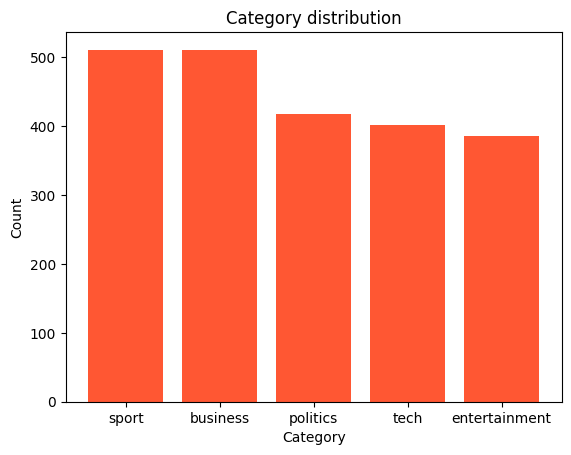

In [7]:
plt.bar(df.category.value_counts().index, df.category.value_counts().values, color='#FF5733')
plt.title("Category distribution")
plt.xlabel("Category")
plt.ylabel("Count")

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, InputLayer, RNN, SimpleRNN, LSTM, GRU, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def data_cleaning(text):
    # Lower the words in the sentence
    cleaned = text.lower()
    # Replace the full stop with a full stop and space
    cleaned = cleaned.replace(".", ". ")
    # Remove the stop words
    tokens = [word for word in cleaned.split() if not word in stop_words]
    # Remove the punctuations
    tokens = [tok.translate(str.maketrans('', '', string.punctuation)) for tok in tokens]

    # Joining the tokens back to form the sentence
    cleaned = " ".join(tokens)

    # Remove any extra spaces
    cleaned = cleaned.strip()

    return cleaned

In [10]:
# Iterating over the rows of the DataFrame using iterrows
# The 'total' argument in tqdm specifies the total number of iterations to show the progress bar
for index, data in tqdm(df.iterrows(), total=df.shape[0]):
    # Apply the data_cleaning function to the 'title' column of each row
    # The cleaned title is assigned back to the DataFrame at the same index
    df.loc[index, 'title'] = data_cleaning(data['title'])
    # At this point, the 'title' column for the current row is updated with the cleaned text

# The progress bar will show the completion percentage and estimated time for processing all rows


  0%|          | 0/2225 [00:00<?, ?it/s]

100%|██████████| 2225/2225 [00:00<00:00, 11186.07it/s]


<Axes: ylabel='title'>

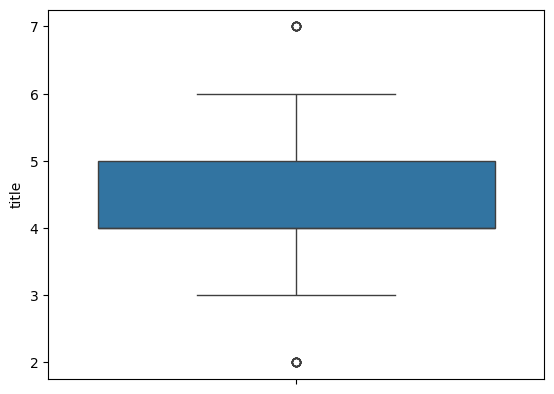

In [11]:
sns.boxplot(df['title'].str.split(" ").str.len())

The main application of a **box plot** is to **visualize the distribution of a dataset** and identify **outliers**, **median**, **quartiles**, and **variability** in a compact and easy-to-read format. It helps in comparing distributions across different categories or datasets.

In [12]:
# Find the maximum sentence length
max_sentence_len = df['title'].str.split(" ").str.len().max()
total_classes = df.category.nunique()

print(f"Maximum sequence length: {max_sentence_len}")
print(f"Total classes: {total_classes}")

Maximum sequence length: 7
Total classes: 5


Output:
Maximum sequence length: 7
Total classes: 5

In [13]:
# Splitting the data to train and test
np.random.seed(100)
train_X, test_X, train_Y, test_Y = train_test_split(df['title'], 
                                                 df['category'], 
                                                 test_size=0.2, 
                                                 random_state=100)

train_X = train_X.reset_index(drop=True)
test_X = test_X.reset_index(drop=True)
train_Y = train_Y.reset_index(drop=True)
test_Y = test_Y.reset_index(drop=True)

In [14]:
unique_counts = df['category'].value_counts()  
print(unique_counts)

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


#### One hot Encode the labels

In [15]:
train_Y = pd.get_dummies(train_Y).values
test_Y = pd.get_dummies(test_Y).values

In [16]:
print(train_Y)
print("\n", "~"*32)
print(test_Y)

[[False False False  True False]
 [False False False  True False]
 [False False False  True False]
 ...
 [ True False False False False]
 [False False False False  True]
 [False False False  True False]]

 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[[False False False False  True]
 [False False False False  True]
 [False False False  True False]
 ...
 [False False  True False False]
 [ True False False False False]
 [False False  True False False]]


In [17]:
# Get validation labels
validation = test_Y.argmax(axis=1) 
# print(validation)

#### Tokenize the input text and pad them

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to tokenize and pad input text
def tokenize_and_pad(input_text, max_length, tokenizer):
    # Convert text into sequences of numbers based on the tokenizer
    tokenized_sequences = tokenizer.texts_to_sequences(input_text)
    # Pad the sequences to the specified max_length
    padded_sequences = pad_sequences(tokenized_sequences, maxlen=max_length, padding='post')
    return padded_sequences


# Step 1: Initialize the tokenizer
text_tokenizer = Tokenizer()
# Step 2: Fit the tokenizer on training data
text_tokenizer.fit_on_texts(train_X)

# Step 3: Tokenize and pad training data
train_padded_sequences = tokenize_and_pad(
    input_text=train_X, 
    max_length=max_sentence_len, 
    tokenizer=text_tokenizer
)

# Step 4: Tokenize and pad test data
test_padded_sequences = tokenize_and_pad(
    input_text=test_X, 
    max_length=max_sentence_len, 
    tokenizer=text_tokenizer
)

In [19]:
# Step 5: Calculate the vocabulary size
# Adding 1 because index 0 is reserved for padding
vocabulary_size = len(text_tokenizer.word_index) + 1

# Print the vocabulary size
print("Overall text vocabulary size:", vocabulary_size)

Overall text vocabulary size: 3360


In [20]:
# Latent dimension: Dimension of the weight matrix U, V, W
latent_dim = 50
# Embedding dimension: Dimension of the word embeddings at the embedding layer
embedding_dim = 100

In [21]:
# Set random seed for reproducibility
seed = 56
tf.random.set_seed(seed)
np.random.seed(seed)

In [22]:
print("Vocabulary size:", vocabulary_size)  # Should be > 0
print("Maximum sequence length:", max_sentence_len)  # Should be > 0
print("Number of classes:", total_classes)  # Should be > 0


Vocabulary size: 3360
Maximum sequence length: 7
Number of classes: 5


In [23]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Set random seed for reproducibility
seed = 56
tf.random.set_seed(seed)
np.random.seed(seed)

# # Parameters
# vocabulary_size = 3360  # Vocabulary size
# max_sentence_len = 7    # Maximum sequence length
# total_classes = 5       # Number of output classes
# latent_dim = 50         # Number of units in RNN
# embedding_dim = 100     # Embedding dimension

# Build the model
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, 
                    output_dim=embedding_dim, 
                    input_length=max_sentence_len, 
                    trainable=True))
model.add(SimpleRNN(units=latent_dim, 
                    recurrent_dropout=0.2, 
                    return_sequences=False, 
                    activation='tanh'))
model.add(Dense(units=total_classes, 
                activation='softmax'))

# Manually build the model with input shape
model.build(input_shape=(None, max_sentence_len))

# Display the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 7, 100)         │       336,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,805 (1.31 MB)

 Trainable params: 343,805 (1.31 MB)

 Non-trainable params: 0 (0.00 B)


### **1. Embedding Layer**

$$
\text{Params} = \text{vocabulary\_size} \times \text{embedding\_dim}
$$

- **`vocabulary_size`**: The size of the vocabulary (number of unique words in the dataset, including padding and special tokens). In your case, this is 3360.
- **`embedding_dim`**: The dimension of each word vector (how many features each word is represented by). In your case, this is 100.

$$
\text{Params} = 3360 \times 100 = 336,000
$$

These parameters are **trainable** because the embedding layer learns the representation of words during training.


### **2. SimpleRNN Layer**

$$
\text{Params} = (\text{latent\_dim} \times (\text{latent\_dim} + \text{input\_dim} + 1))
$$

- **`latent_dim`**: The number of units (neurons) in the RNN layer, which controls the size of the hidden state. In your case, this is 50.
- **`input_dim`**: The size of each timestep input, which equals the `embedding_dim` from the previous layer (100).
- The **`+1`** accounts for the bias term in the RNN computation.

$$
\text{Params} = 50 \times (50 + 100 + 1) = 50 \times 151 = 7,550
$$

These parameters are **trainable** because the RNN layer learns weights for input-to-hidden, hidden-to-hidden, and biases during training.


### **3. Dense Layer**

$$
\text{Params} = (\text{units} \times \text{input\_dim}) + \text{units}
$$

- **`units`**: The number of output classes. In your case, this is 5 (for multi-class classification).
- **`input_dim`**: The size of the input from the previous layer, which is the `latent_dim` (50).
- The **`+ units`** accounts for the bias term in the Dense layer.

$$
\text{Params} = (5 \times 50) + 5 = 250 + 5 = 255
$$

These parameters are **trainable** because the Dense layer learns weights and biases during training.



### **4. Total Parameters**

$$
\text{Total Params} = \text{Params from Embedding} + \text{Params from SimpleRNN} + \text{Params from Dense}
$$

$$
\text{Total Params} = 336,000 + 7,550 + 255 = 343,805
$$



### Final Breakdown:
| **Layer**         | **Params**      | **Explanation**                                       |
|--------------------|-----------------|-------------------------------------------------------|
| **Embedding**      | 336,000         | $$3360 \times 100$$|
| **SimpleRNN**      | 7,550           | $$50 \times (50 + 100 + 1)$$                     |
| **Dense**          | 255             | $$(5 \times 50) + 5$$                              |
| **Total**          | 343,805         | Sum of all layers' parameters                        |


#### Notes:
1. **Trainable Parameters**:
   - All the parameters in this model are **trainable**, meaning they will be updated during backpropagation.
2. **Output Shapes**:
   - **Embedding Layer**: Outputs a sequence of shape `(batch_size, 7, 100)`, where 7 is the max sequence length and 100 is the embedding dimension.
   - **SimpleRNN Layer**: Outputs the final hidden state of shape `(batch_size, 50)`, where 50 is the latent dimension.
   - **Dense Layer**: Outputs probabilities for 5 classes with shape `(batch_size, 5)`.


In [24]:
# Compile the model
model.compile(
    optimizer='Adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [25]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max', 
    verbose=1, 
    patience=5  # Stop training if no improvement for 5 epochs
)

In [26]:
# Train the model
history = model.fit(
    x=train_padded_sequences, y=train_Y, 
    validation_data=(test_padded_sequences, test_Y), 
    batch_size=64, epochs=5, 
    callbacks=[early_stopping]  # Apply early stopping
    )

Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2182 - loss: 1.6124 - val_accuracy: 0.2562 - val_loss: 1.5702
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5048 - loss: 1.3733 - val_accuracy: 0.4854 - val_loss: 1.3523
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7670 - loss: 0.8569 - val_accuracy: 0.5955 - val_loss: 1.1142
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9120 - loss: 0.3591 - val_accuracy: 0.6404 - val_loss: 1.1180
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9641 - loss: 0.1699 - val_accuracy: 0.6270 - val_loss: 1.2991


In [27]:
import pickle
# Save the model
model.save('model.h5')

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(text_tokenizer, handle)

In [28]:
# Make predictions on the test dataset
prediction = model.predict(test_padded_sequences)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [29]:
prediction = prediction.argmax(axis=1)

In [30]:
print(f"Accuracy: {accuracy_score(prediction, validation)}")

Accuracy: 0.6269662921348315


In [31]:
cm = confusion_matrix(validation, prediction)

Text(0.5, 1.0, 'Confusion Matrix')

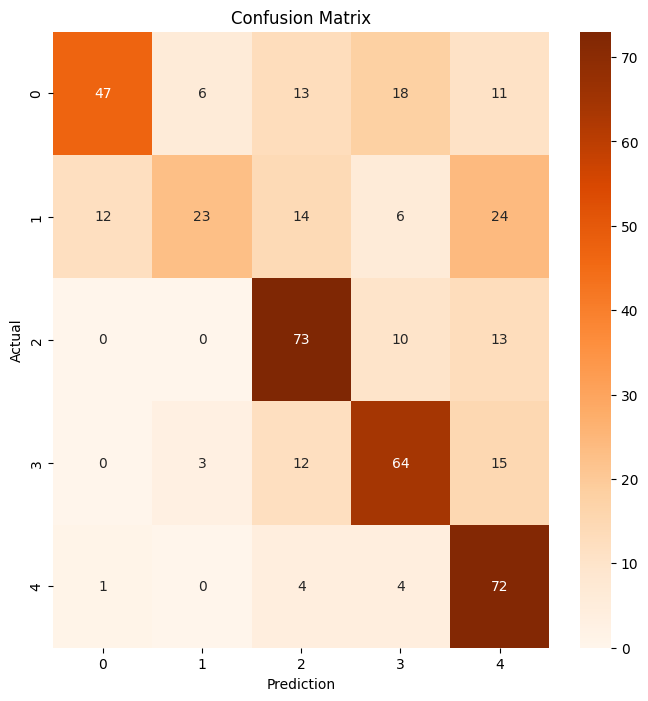

In [32]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Oranges")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

In [33]:
df.head()

,category,filename,title,content
0,business,001.txt,ad sales boost time warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,dollar gains greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,high fuel prices hit bas profits,British Airways has blamed high fuel prices f...
4,business,005.txt,pernod takeover talk lifts domecq,Shares in UK drinks and food firm Allied Dome...


In [34]:
print(train_Y.sum(axis=0))  # Check class distribution


[415 307 321 417 320]


In [36]:
categories = ["sport", "business", "politics", "tech", "entertainment"]

titles = [
    "parmalat boasts doubled profits", 
    "muslim police stops more likely", 
    "New Tech Gadgets Revolutionize the Market", 
    "indonesians face fuel price rise", 
    "us cyber security chief resigns"
]

for title in titles:
    sequence = tokenize_and_pad([title], max_length=7, tokenizer=text_tokenizer)
    prediction = model.predict(sequence)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    print(f"Title: {title}, Predicted Category: {categories[predicted_class_index]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Title: parmalat boasts doubled profits, Predicted Category: sport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Title: muslim police stops more likely, Predicted Category: politics
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Title: New Tech Gadgets Revolutionize the Market, Predicted Category: entertainment
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Title: indonesians face fuel price rise, Predicted Category: sport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Title: us cyber security chief resigns, Predicted Category: entertainment
